<a href="https://colab.research.google.com/github/Logan-Stark/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

# DATA IMPORT AND WRANGLING

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

## Spliting data into train and val

In [3]:
# Split train into train & val
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

In [4]:
# from pandas_profiling import ProfileReport
# profile = ProfileReport(train, minimal=True).to_notebook_iframe()

# profile

# Wrangling and Feature engineering

In [5]:
# added new features to our data and got rid of duplicates
import numpy as np
import category_encoders as ce
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
 
    # Stop CopyWarning
    X = X.copy()
    
    # get rid of irrelevant Latitude data
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['longitude', 'latitude', 'num_private', 'district_code'
    ,'population', 'construction_year', 'gps_height', 'amount_tsh']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)

    # converting date recorderd into int and making new feature
    X['date_recorded'] = pd.to_datetime(X['date_recorded'])
    X['date_recorded'] = X['date_recorded'].dt.year
    X['date_recorded'] =X['date_recorded'].astype(int)
    X['years_since_constr'] = X['date_recorded'] - X['construction_year']   
    
    # making a feature based on correlation between salty and other for water quality and extraction
    X['water_quality_extraction_method']= (X['water_quality']== 'salty') & (X['extraction_type_class'] == 'other')

    # making feature based on correlation between salty and dry for water quality and quantity dry
    X['quality_and_quantity'] = (X['water_quality'] == 'salty') | (X['quantity']== 'dry')

    # making feature based on correlation between salty and dry for water quality and quantity dry
    X['Year_built_insufficientsupply'] = (X['quantity']=='insufficient') | (X['construction_year']<= 2004)

    # making feature based on correlation between salty and dry for water quality and quantity dry
    X['Year_built_sufficientsupply'] = (X['quantity']=='enough') | (X['construction_year']>= 2004)

    # making feature based on correlation between gravity and insufficent
    X['extraction_gravity_insufficent'] = (X['quantity']=='insufficient') & (X['extraction_type_class'] == 'gravity')

    #X['gps_enough']= (X['gps_height']>= 1550) & (X['quantity_group']== 'enough')

    # quantity & quantity_group are duplicates, so drop one
    X = X.drop(columns='quantity')
    X = X.drop(columns='extraction_type_group')
    X = X.drop(columns='management_group')
    X = X.drop(columns='payment_type')
    X = X.drop(columns='quality_group')
    X = X.drop(columns='source_type')
    X = X.drop(columns='waterpoint_type_group')
    X = X.drop(columns='num_private')
    #X = X.drop(columns='amount_tsh')
    #X = X.drop(columns='latitude')
    #X = X.drop(columns='longitude')
    #X = X.drop(columns='gps_height')
    X = X.drop(columns='scheme_name')
    #X = X.drop(columns='population')
    # return the wrangled dataframe
    return X

# DRY programming DON'T REPEAT YOURSELF
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
# select our target 
target = 'status_group'

# make train without our target or id
train_features = train.drop(columns=[target, 'id'])

# make numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# make a cardinality feature to help filter
cardinality = train_features.select_dtypes(exclude='number').nunique()

# get a list of relevant categorical data
categorical_features = cardinality[cardinality <=50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'date_recorded', 'gps_height', 'longitude', 'latitude', 'region_code', 'district_code', 'population', 'construction_year', 'years_since_constr', 'basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_class', 'management', 'payment', 'water_quality', 'quantity_group', 'source', 'source_class', 'waterpoint_type', 'water_quality_extraction_method', 'quality_and_quantity', 'Year_built_insufficientsupply', 'Year_built_sufficientsupply', 'extraction_gravity_insufficent']


In [7]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [18]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)


(47520, 30)
(47520,)
(11880, 30)
(11880,)
(14358, 30)


In [35]:
X_train = pd.concat([X_train,X_val])
y_train = pd.concat([y_train,y_val])

In [ ]:
min_samples_split=4,
min_samples_leaf=2,
max_leaf_nodes=10,
min_samples_split=4,
                      min_samples_leaf=2,
                      max_leaf_nodes=10,
                      
                     
                      
                      n_jobs=-1,
                      max_depth=20))

# CURRENT MODEL

In [103]:
# Same as above but with ordinal encoder

model2 = Pipeline([
                  ('ohe', OrdinalEncoder(drop_invariant=True)),
                  ('impute', SimpleImputer(strategy='median')),
                  ('scaler', StandardScaler()),
                  ('classifier', RandomForestClassifier(
                      n_estimators=2000,
                      n_jobs=-1,
                      max_depth=10,
                      min_samples_split=8,
                      min_samples_leaf=2,
                      max_leaf_nodes=10,
                      max_features=6
))
                     
])

model2.fit(X_train, y_train)

print('training accuracy:', model2.score(X_train, y_train))


training accuracy: 0.7116835016835017


In [105]:
y_pred = model2.predict(X_test)

In [106]:
DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('your-submission-filename13.csv', index=False)

In [107]:
from google.colab import files
files.download('your-submission-filename13.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## important features for features

In [ ]:
12.19,12.55,11.27

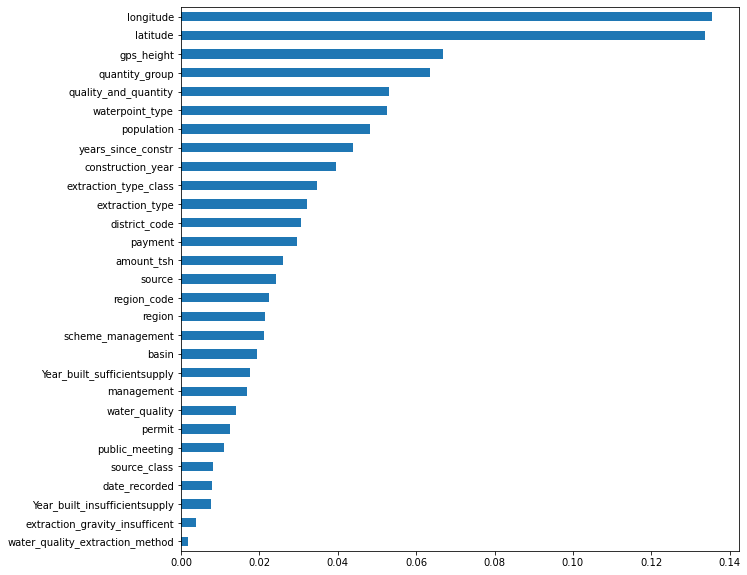

In [9]:
import matplotlib.pyplot as plt
model = model2.named_steps['classifier']
encoder = model2.named_steps['ohe']
encoded_columns = encoder.transform(X_train).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,10))
importances.sort_values().plot.barh()

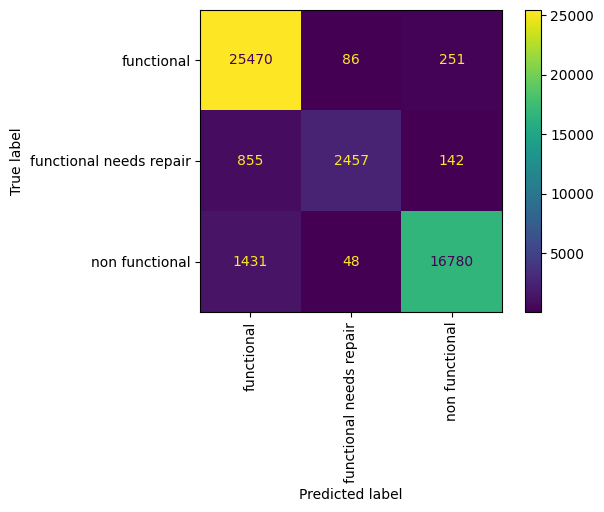

In [11]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
plt.rcParams['figure.dpi'] =100
plot_confusion_matrix(model2,X_train,y_train, values_format= '.0f', xticks_rotation= 'vertical')

In [21]:
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.91      0.85      6452
functional needs repair       0.58      0.29      0.39       863
         non functional       0.85      0.77      0.81      4565

               accuracy                           0.81     11880
              macro avg       0.74      0.66      0.68     11880
           weighted avg       0.80      0.81      0.80     11880



In [ ]:
y_train = y_train != 'functional'
y_val = y_val != 'functional'